In [76]:
import pandas as pd

from src.network.ConnectPaperOnDOI import PaperConnector

In [77]:
# read in all data/processed/allmpnet-embeddings/allmpnet-embeddings.pkl
df = pd.read_pickle("../data/03-interim/allmpnet-embeddings/allmpnet-embeddings.pkl")

In [78]:
df["merged_dois"].fillna("", inplace=True)
connector = PaperConnector(df=df)

# Connect papers based on titles and DOIs
connector.connect_papers()

Papers sorted by year.
Starting paper connection...


100%|██████████| 35153/35153 [00:04<00:00, 7315.79it/s] 


Paper connection finished.
Average number of matches on DOIs: 8.276420220180354


In [79]:
connector.df.columns

Index(['authors', 'title', 'year', 'cited_by', 'doi', 'link', 'abstract',
       'author_keywords', 'index_keywords', 'references', 'pubmed_id',
       'document_type', 'source', 'eid', 'journal', 'first_author', 'nameyear',
       'unique_nameyear', 'title_abstract', 'paper_id', 'oc_refs', 'oc_dois',
       'cr_refs', 'cr_dois', 'merged_dois', 'oc_nr_dois', 'cr_nr_dois',
       'merged_nr_dois', 'embeddings_allmpnet', 'paper_ids_matched_on_dois'],
      dtype='object')

In [80]:
df_connected = connector.df

In [81]:
df_connected["nr_of_links"] = df_connected["paper_ids_matched_on_dois"].apply(
    lambda x: len(x) if x[0] != "no doi match" else 0
)

<Axes: xlabel='year'>

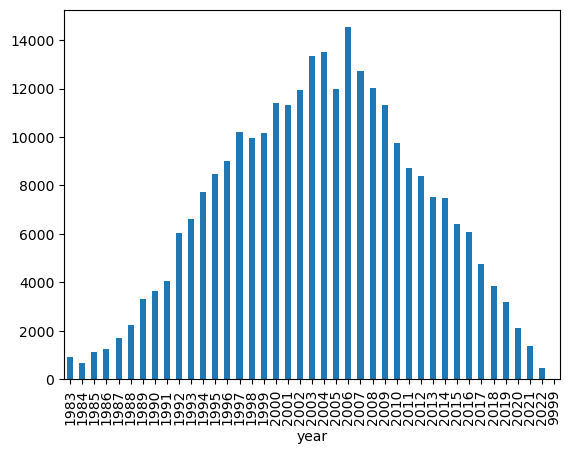

In [82]:
# print the nr_of_links grouped by year
df_connected.groupby("year")["nr_of_links"].sum().plot(kind="bar")

In [83]:
df_connected.columns

Index(['authors', 'title', 'year', 'cited_by', 'doi', 'link', 'abstract',
       'author_keywords', 'index_keywords', 'references', 'pubmed_id',
       'document_type', 'source', 'eid', 'journal', 'first_author', 'nameyear',
       'unique_nameyear', 'title_abstract', 'paper_id', 'oc_refs', 'oc_dois',
       'cr_refs', 'cr_dois', 'merged_dois', 'oc_nr_dois', 'cr_nr_dois',
       'merged_nr_dois', 'embeddings_allmpnet', 'paper_ids_matched_on_dois',
       'nr_of_links'],
      dtype='object')

In [84]:
df_connected["title_abstract"][35152]

'High affinity binding of paroxetine and imipramine to human platelet membranes. Paroxetine one of the most potent and specific serotonin uptake inhibitors was tritiated and used for binding studies with human platelet membranes. Specific high affinity binding was demonstrated. The binding was compared with imipramine binding; it was found that the maximal binding (Bmax) was the same for paroxetine and imipramine whereas the affinity was much higher for paroxetine (KD 0.08 nM and 0.56 nM for paroxetine and imipramine binding respectively). IC50 was calculated for the inhibition of paroxetine and imipramine binding by a number of antidepressants; the corresponding Hill coefficients were also calculated.'

In [85]:
df_connected.shape

(35153, 31)

In [86]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


def compute_cosine_similarity_matrix(
    df, embeddings_column, sample_size=1000, random_state=1887
):
    """
    Computes the cosine similarity matrix for the embeddings in a DataFrame column.

    Parameters:
    df (DataFrame): The DataFrame containing the embeddings.
    embeddings_column (str): The name of the column containing embeddings.
    sample_size (int, optional): The number of samples to consider. Defaults to 1000.
    random_state (int, optional): The seed for random sampling. Defaults to 1887.

    Returns:
    ndarray: A cosine similarity matrix.
    """

    # Sample the DataFrame and reset the index
    df_sampled = df.sample(sample_size, random_state=random_state).reset_index(
        drop=True
    )

    # Convert the embeddings column to a 2D NumPy array
    embeddings = np.stack(df_sampled[embeddings_column])

    # Check for NaN or infinite values and handle them
    embeddings = np.nan_to_num(embeddings)

    # Normalize the embeddings to unit length
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized_embeddings = embeddings / norms

    # Compute the cosine similarity matrix
    cosine_similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)

    return cosine_similarity_matrix


# Usage example:
# cosine_similarity_matrix = compute_cosine_similarity_matrix(df_connected, "embeddings_allmpnet")

In [102]:
len(df_connected) * len(df_connected)

1235733409

In [99]:
def is_pair_already_printed(p1, p2, printed_pairs):
    """Check if the pair has already been printed."""
    return (p1, p2) in printed_pairs or (p2, p1) in printed_pairs


def print_second_most_similar(df, cosine_similarity_matrix):
    printed_pairs = set()

    for i, row in df.iterrows():
        sorted_indices = np.argsort(cosine_similarity_matrix[i])
        second_most_similar = sorted_indices[-2]  # -1 is the most similar (itself)

        # Skip if the pair has already been printed
        if is_pair_already_printed(i, second_most_similar, printed_pairs):
            continue

        # Handle the case where the most similar paper might be the paper itself
        if second_most_similar == i:
            second_most_similar = sorted_indices[-3]

        # Check if the similarity is above the threshold
        if cosine_similarity_matrix[i][second_most_similar] > 0.95:
            printed_pairs.add((i, second_most_similar))

            print(f"Paper {i}: {row['title']}")
            print("Second most similar paper:")
            print(
                f"Paper {second_most_similar}: {df.iloc[second_most_similar]['title']}"
            )
            print(
                f"Cosine similarity: {cosine_similarity_matrix[i][second_most_similar]}"
            )
            print("----")


print_second_most_similar(df_sub, cosine_similarity_matrix)

Paper 26: Efficacy of Phosphodiesterase-5 Inhibitor in Men With Premature Ejaculation: A New Systematic Review and Meta-analysis
Second most similar paper:
Paper 583: Phosphodiesterase Type 5 Inhibitors for Premature Ejaculation: A Systematic Review and Meta-analysis
Cosine similarity: 0.9566106530320228
----
Paper 507: Remission with mirtazapine and selective serotonin reuptake inhibitors: A meta-analysis of individual patient data from 15 controlled trials of acute phase treatment of major depression
Second most similar paper:
Paper 843: A meta-analysis of clinical trials comparing mirtazapine with selective serotonin reuptake inhibitors for the treatment of major depressive disorder
Cosine similarity: 0.9550023293431514
----
Paper 572: Treatment of depression in cardiovascular disease
Second most similar paper:
Paper 874: Management of depression in patients with comorbid cardiovascular disease
Cosine similarity: 0.9520255672155236
----


In [94]:
# how many pairs are above .9?
cosine_similarity_matrix[cosine_similarity_matrix > 0.9].shape

(1052,)

In [97]:
df_sub["title_abstract"][26]

2015

In [98]:
df_sub["title_abstract"][583]

2017